<a href="https://colab.research.google.com/github/Rom1deTroyes/Segmentation_Lesions_Pulmonaires/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://simplonline.co/_next/image?url=https%3A%2F%2Fsimplonline-v3-prod.s3.eu-west-3.amazonaws.com%2Fmedia%2Fimage%2Fjpg%2Fcb4b9733-3fff-43d0-a1c7-e469e016b978.jpg&w=1280&q=75)

# Segmentation des lésions pulmonaires

Ce brief a pour objectif de manipuler une architecture CNN pour réaliser la segmentation.

Dans ce brief, nous appliquons un apprentissage supervisé pour détecter les lésions pulmonaires à partir d’une image.


In [1]:
# Récpération des données
!git clone https://github.com/Rom1deTroyes/Segmentation_Lesions_Pulmonaires  # clone
%cd Segmentation_Lesions_Pulmonaires
#%pip install -qr requirements.txt  # install

Cloning into 'Segmentation_Lesions_Pulmonaires'...
remote: Enumerating objects: 5520, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5520 (delta 15), reused 14 (delta 13), pack-reused 5501
Receiving objects: 100% (5520/5520), 949.05 MiB | 19.58 MiB/s, done.
Resolving deltas: 100% (1747/1747), done.
Checking out files: 100% (5466/5466), done.
/content/Segmentation_Lesions_Pulmonaires


In [ ]:
#!pip list --format=freeze

In [2]:
import cv2
import os
import random

import numpy as np

from tqdm.notebook import tqdm

## Partie 1 : Base de données

### Charger les images

#### **Redimensionner** les images selon le modèle souhaité.

In [3]:
width=256
height=256

In [4]:
dir_img="frames/"
dir_mask="masks/"

tab_img=[]
tab_mask=[]

# Récupération de la liste des fichiers images
files = os.listdir(dir_img)
# Mélange des images 
random.Random(42).shuffle(files)

for n, i in tqdm(enumerate(files), total=len(files)):

    tab_img.append(cv2.resize(cv2.imread(dir_img+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)  # Image vide (h,w, N) avec N = nombre de classes
    img_mask_result[:,:,0][img_mask==255]=1.  ## Pour toutes les h,w de la profondeur 0 : Quand Couleur 255 (blanc) => Classe 1
    tab_mask.append(img_mask_result)

# Préparation du Tenseur
tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)

  0%|          | 0/2729 [00:00<?, ?it/s]

In [5]:
# Vérification des données importées
print(tab_img.shape)
print(tab_mask.shape)

(2729, 256, 256, 3)
(2729, 256, 256, 1)


On a autant d'images que de masques : tout c'est bien passé.

#### Séparation des données en données d’apprentissage, validation et test.

In [6]:
# Ratios Train / Test / Validation
val_num = 15/100
test_num = 20/100

In [7]:
# Indices des slices
val_split = int(1 - val_num * len(tab_img))
test_split = int(1 - test_num * (len(tab_img) - val_split))

#split Train
x_train = tab_img[0:test_split]
y_train = tab_mask[0:test_split]

#split Test
x_test = tab_img[test_split:val_split]
y_test = tab_mask[test_split:val_split]

#split Validation
x_valid = tab_img[val_split:]
y_valid = tab_mask[val_split:]

# Vérification de la répartition des données
print(x_train.shape, x_test.shape, x_valid.shape)
print(y_train.shape, y_test.shape, y_valid.shape)


(2103, 256, 256, 3) (218, 256, 256, 3) (408, 256, 256, 3)
(2103, 256, 256, 1) (218, 256, 256, 1) (408, 256, 256, 1)


Vérification de la répartition des données Train/Test/Validation

In [8]:
print(f"Apprentissage : {round(x_train.shape[0]*100/len(tab_img))}%")
print(f"Test : {round(x_test.shape[0]*100/x_train.shape[0])}%")
print(f"Validation : {round(x_valid.shape[0]*100/len(tab_img))}%")

Apprentissage : 77%
Test : 10%
Validation : 15%


## Appliquer la data augmentation.

In [ ]:
from keras.preprocessing import image

In [ ]:
## Code : Amine
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# 0.9 = 90% Train + 10% Validation
tv_split = 0.9

# Apprentissage (+ standardisation)
seed = 42
image_datagen.fit(tab_img[:int(tab_img.shape[0]*tv_split)], augment=True, seed=seed)
mask_datagen.fit(tab_mask[:int(tab_mask.shape[0]*tv_split)], augment=True, seed=seed)

# Application de la Data Augmentation
BATCH_SIZE = 32
x=image_datagen.flow(tab_img[:int(tab_img.shape[0]*tv_split)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(tab_mask[:int(tab_mask.shape[0]*tv_split)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(tab_img[int(tab_img.shape[0]*tv_split):], augment=True, seed=seed)
mask_datagen_val.fit(tab_mask[int(tab_mask.shape[0]*tv_split):], augment=True, seed=seed)

x_val=image_datagen_val.flow(tab_img[int(tab_img.shape[0]*tv_split):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(tab_mask[int(tab_mask.shape[0]*tv_split):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

#### Autre façon de faire (Amine)



```python
Valid_dir_img="Data_Valid/Data/"
Valid_dir_mask="Data_Valid/Gr_Th/"

width=512
height=512
channels=3

Valid_tab_img=[]
Valid_tab_mask=[]

for n, i in tqdm(enumerate(os.listdir(Valid_dir_img)), total=len(os.listdir(Valid_dir_img))):
    Valid_tab_img.append(cv2.resize(cv2.imread(Valid_dir_img+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(Valid_dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)
    img_mask_result[:,:,0][img_mask==255]=1.
    Valid_tab_mask.append(img_mask_result)

tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)

Valid_tab_img=np.array(Valid_tab_img)
Valid_tab_mask=np.array(Valid_tab_mask)

from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

seed = 42
image_datagen.fit(tab_img, augment=True, seed=seed)
mask_datagen.fit(tab_mask, augment=True, seed=seed)

BATCH_SIZE = 32
x=image_datagen.flow(tab_img,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(tab_mask,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(Valid_tab_img, augment=True, seed=seed)
mask_datagen_val.fit(Valid_tab_mask, augment=True, seed=seed)

x_val=image_datagen_val.flow(Valid_tab_img,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Valid_tab_mask,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)
```

### Visualiser les images de CT et sa vérité terrain (segmentation manuelle).

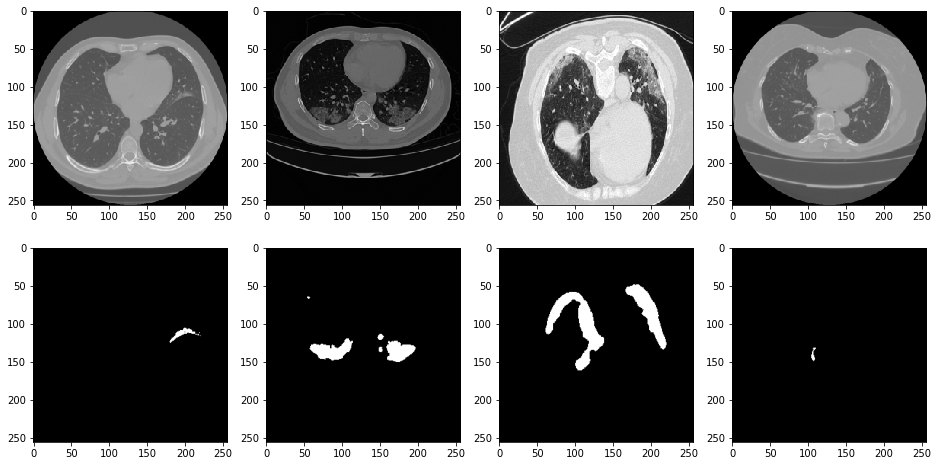

In [9]:
from matplotlib import pyplot as plt

n = 4
h = 4
f, axarr = plt.subplots(2,n, figsize=(h*n,2*h))

for c in range(n):
  r = c * int(len(tab_img)/(n-1))
  axarr[0,c].imshow(tab_img[r], interpolation='nearest')
  axarr[1,c].imshow(tab_mask[r,:,:,0], cmap='gray')



## Partie 2 : Transfer Learning


### Préparation du modèle de segmentation

In [10]:
# Installation des bibliothèques
!pip install -q segmentation-models

     |████████████████████████████████| 50 kB 8.1 MB/s 


In [11]:
# Import des bibliothèques
import segmentation_models as sm
from segmentation_models import Unet

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [12]:
model_path = 'Unet_weights.h5'

#### Définition du modèle et des métriques

In [13]:
n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'  # sigmoid si sortie binaire, sinon softmax

width=256
height=256

model = Unet('resnet34', encoder_weights='imagenet', classes=1, input_shape=(width, height, 3), activation=activation)  #  input_shape=(width, height, 3), 

# metrics = ["acc"]
metrics = ["acc", sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# compile keras model with defined optimozer, loss and metrics
model.compile('Adam', loss="binary_crossentropy", metrics=metrics)

# define callbacks for learning rate scheduling and best checkpoints saving
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    ReduceLROnPlateau(),
]


85532672/85521592 [==============================] - 1s 0us/step


In [14]:
from keras.models import load_model
if os.path.exists(model_path) :
    model.load_weights(model_path)  # Rechargement du modèle si déjà enregistré

#### Apprentissage

Application d'un Transfer Learning sur l'architecture.

In [ ]:
EPOCHS = 10

results = model.fit(train_generator,
                    steps_per_epoch=1000,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    validation_steps=500,
                    callbacks=callbacks
                    )

model.save_weights(model_path)

Epoch 1/10
1000/1000 [==============================] - 820s 793ms/step - loss: 0.0501 - acc: 0.9815 - iou_score: 0.5401 - f1-score: 0.6675 - val_loss: 0.0328 - val_acc: 0.9906 - val_iou_score: 0.3544 - val_f1-score: 0.5207
Epoch 2/10
1000/1000 [==============================] - 776s 777ms/step - loss: 0.0138 - acc: 0.9919 - iou_score: 0.6788 - f1-score: 0.8078 - val_loss: 0.0151 - val_acc: 0.9944 - val_iou_score: 0.6347 - val_f1-score: 0.7743
Epoch 3/10
1000/1000 [==============================] - 774s 774ms/step - loss: 0.0120 - acc: 0.9924 - iou_score: 0.7081 - f1-score: 0.8285 - val_loss: 0.0124 - val_acc: 0.9952 - val_iou_score: 0.6878 - val_f1-score: 0.8140
Epoch 4/10
1000/1000 [==============================] - 810s 811ms/step - loss: 0.0124 - acc: 0.9924 - iou_score: 0.7036 - f1-score: 0.8246 - val_loss: 0.0144 - val_acc: 0.9946 - val_iou_score: 0.6367 - val_f1-score: 0.7762
Epoch 5/10
1000/1000 [==============================] - 792s 793ms/step - loss: 0.0111 - acc: 0.9927 - i

In [ ]:
model.save_weights(model_path)

#### Visualisation des métriques

In [ ]:
results.history

{'acc': [0.9815385341644287,
  0.9918970465660095,
  0.9924157857894897,
  0.9923507571220398,
  0.9927321672439575,
  0.9923380017280579,
  0.9925134778022766,
  0.9930477142333984,
  0.9931462407112122,
  0.9932763576507568],
 'f1-score': [0.6674961447715759,
  0.8078294992446899,
  0.8284763693809509,
  0.8245774507522583,
  0.8395788073539734,
  0.8241828083992004,
  0.8316513299942017,
  0.8523992896080017,
  0.8565295934677124,
  0.8616954684257507],
 'iou_score': [0.5401369333267212,
  0.6788462400436401,
  0.7080639004707336,
  0.7036285400390625,
  0.7247545123100281,
  0.7047519087791443,
  0.7127576470375061,
  0.743953287601471,
  0.7498461008071899,
  0.7580294609069824],
 'loss': [0.05010369047522545,
  0.01375533826649189,
  0.012010629288852215,
  0.012370100244879723,
  0.011072798632085323,
  0.012540917843580246,
  0.011732972227036953,
  0.010223387740552425,
  0.009851362556219101,
  0.00958073791116476],
 'val_acc': [0.9906498789787292,
  0.9944131970405579,
  0.9

#### Courbes Accuracy, F1-Score, iuo, Loss

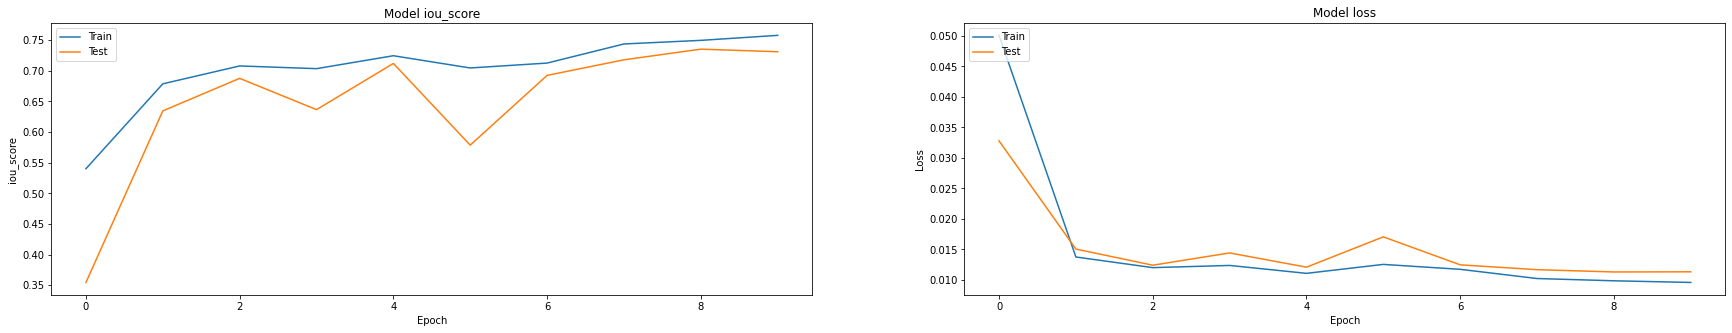

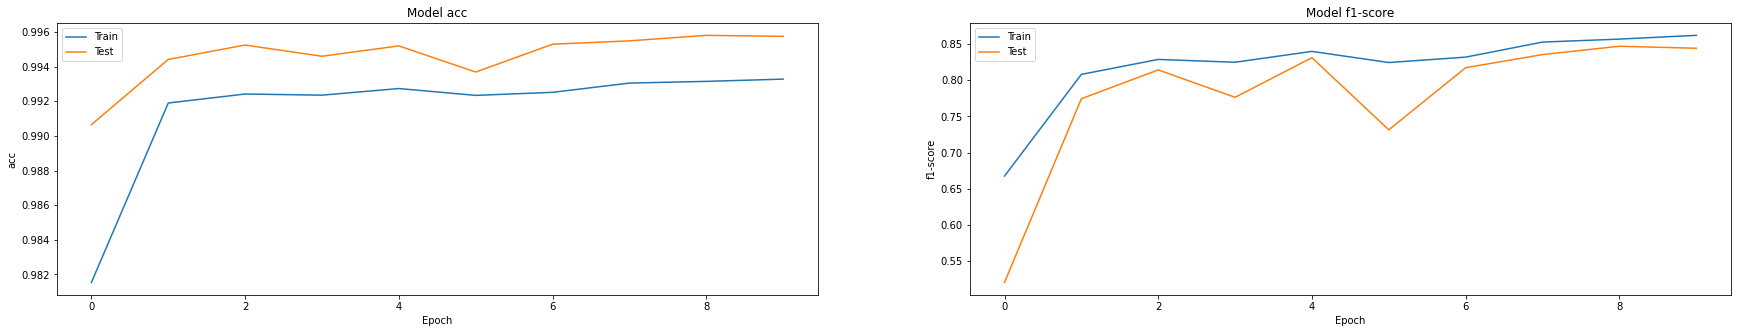

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(results.history['iou_score'])
plt.plot(results.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation acc values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1-score values
plt.subplot(122)
plt.plot(results.history['f1-score'])
plt.plot(results.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Validation

Code : Amine

In [72]:
X_test = x_test
Y_test = y_test

In [66]:
def SEG_EVAL(Seg,GT):
    # Seg : Segmented image, must be binary (1 = regions of interest 0 = background)
    # GT : Ground truth, must be binary (1 = regions of interest 0 = background)
    Seg.astype(np.bool)
    GT.astype(np.bool)
    
    #dice_coefficient
    intersection = np.logical_and(Seg, GT)
    dice_coefficient = 2. * intersection.sum() / (Seg.sum() + GT.sum())
    
    #IoU
    TP = np.logical_and(Seg, GT)
    IoU = TP.sum() / (GT.sum() + Seg.sum() - TP.sum())
    
    #recall
    recall = TP.sum() / GT.sum()
    
    #precision
    precision = TP.sum() / Seg.sum()
    
    EVAL = [dice_coefficient,IoU,recall,precision]
    
    return EVAL


def VIS_EVAL(Image, Seg, GT, option = 'contour'):
    # Image : Gray image
    # Seg : Segmented image, must be binary (1 = regions of interest 0 = background)
    # GT : Ground truth, must be binary (1 = regions of interest 0 = background)
    # option = 'contour' For contour plotting
    # option = 'region' For color the region
       
    Image = cv2.cvtColor(np.array(Image, np.uint8), cv2.COLOR_GRAY2RGB)
    GT = np.array(255*GT, dtype=np.uint8)
    Seg = np.array(255*Seg, dtype=np.uint8)
    GT = cv2.cvtColor(GT, cv2.COLOR_GRAY2RGB)
    Seg = cv2.cvtColor(Seg, cv2.COLOR_GRAY2RGB)
        
    if option == 'region':
        GT[:, :, 1:2] = 0*GT[:, :, 1:2]
        Seg[:, :, 0] = 0*Seg[:, :, 0]
        Seg[:, :, 2] = 0*Seg[:, :, 2]
        
        VIS_Seg = cv2.addWeighted(Image, 1, Seg, 0.5, 0)
        VIS_GT = cv2.addWeighted(Image, 1, GT, 0.5, 0)
          
    elif option == 'contour':
       
        contours_GT = cv2.Canny(GT, 250, 260) 
        contours_Seg = cv2.Canny(Seg, 250, 260) 
        
        contours_GT = cv2.cvtColor(contours_GT, cv2.COLOR_GRAY2RGB)
        contours_Seg = cv2.cvtColor(contours_Seg, cv2.COLOR_GRAY2RGB)
        
        contours_GT[:, :, 1:2] = 0*contours_GT[:, :, 1:2]
        contours_Seg[:, :, 0] = 0*contours_Seg[:, :, 0]
        contours_Seg[:, :, 2] = 0*contours_Seg[:, :, 2]
        
        VIS_Seg = cv2.addWeighted(Image, 1, contours_Seg, 0.5, 0)
        VIS_GT = cv2.addWeighted(Image, 1, contours_GT, 0.5, 0)
        
    return VIS_Seg,VIS_GT


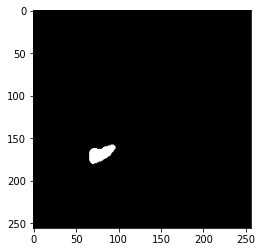

In [68]:
pred = model.predict(X_test)

plt.imshow(pred[7,:,:,0]>=0.5, cmap="gray")

In [69]:
id = 7

Image = X_test[id,:,:,0]*255
Seg = (pred[id,:,:,0]>=0.5).astype(int)
GT = Y_test[id,:,:,0]

VIS_Seg, VIS_GT = VIS_EVAL(Image, Seg, GT, option = 'region')

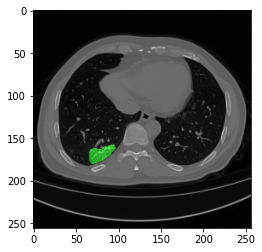

In [70]:
plt.imshow(VIS_Seg)

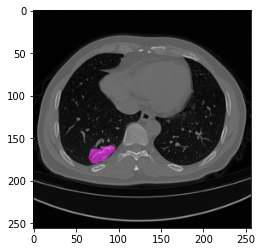

In [71]:
plt.imshow(VIS_GT)

In [54]:
SEG_EVAL(Seg,GT)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


[0.9487485101311085,
 0.9024943310657596,
 0.9707317073170731,
 0.9277389277389277]

## Test

In [73]:
Eval = []

for i in os.listdir(dir_img):
    Image_Test = cv2.resize(cv2.imread(dir_img+i), (width, height))/255
    Image = cv2.resize(cv2.imread(dir_img+i), (width, height))[:,:,2]
    VT=cv2.resize(cv2.imread(dir_mask+i), (width, height))[:,:,2]
    VT=(VT==255).astype(int)

    Image_Test = np.expand_dims(Image_Test, axis=0)
    Seg = model.predict(Image_Test)
    Seg = ((Seg[0,:,:,0])>=0.5).astype(int)

    Eval.append(SEG_EVAL(Seg,VT))

    VIS_Seg,VIS_GT=VIS_EVAL(Image, Seg, VT, option = 'region')
    cv2.imwrite('CNN_Results/Seg_'+i, VIS_Seg)
    cv2.imwrite('CNN_Results/GT_'+i, VIS_GT)
    
np.savetxt("CNN_Results.csv", Eval, delimiter=",")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid 

In [74]:
Eval

[[0.9377682403433476,
  0.8828282828282829,
  0.9161425576519916,
  0.9604395604395605],
 [0.714078374455733, 0.5553047404063205, 0.640625, 0.8065573770491803],
 [0.9240490006447454,
  0.8588207094918504,
  0.914030612244898,
  0.9342894393741852],
 [0.5294117647058824, 0.36, 0.375, 0.9],
 [0.8903493600830162,
  0.8023690773067331,
  0.9153627311522048,
  0.8666666666666667],
 [0.6307977736549165,
  0.46070460704607047,
  0.5396825396825397,
  0.7589285714285714],
 [0.9075471698113208,
  0.8307426597582038,
  0.9339805825242719,
  0.8825688073394495],
 [0.9512367491166078,
  0.9070080862533693,
  0.9438990182328191,
  0.9586894586894587],
 [0.9296139563001986,
  0.8684847506858158,
  0.9019607843137255,
  0.9590163934426229],
 [0.9089309282886053,
  0.8330645161290322,
  0.8563730569948187,
  0.9683618467307241],
 [0.7301587301587301, 0.575, 0.7931034482758621, 0.6764705882352942],
 [0.9039913700107874,
  0.8248031496062992,
  0.9249448123620309,
  0.8839662447257384],
 [0.701986754966

### Affichage de l'image détourée par sa prédiction

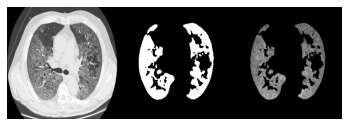

In [81]:
from PIL import Image

#width = height = 256

raw = Image.open('test.png')

raw = np.array(raw.resize((width, height)))/255.
raw = raw[:,:,0:3]

#predict the mask
mask_pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk = mask_pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.savefig('test-pred.png', dpi = 300, bbox_inches='tight')
plt.show()

### Différence entre prédiction et réalité de terrain

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


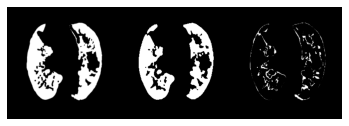

In [82]:
from PIL import Image

#width = height = 256

raw = Image.open('test.png')

raw = np.array(raw.resize((width, height)))/255.
raw = raw[:,:,0:3]

#predict the mask
mask_pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk = mask_pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#load Ground Truth
gt = Image.open('test-mask.png')
gt = np.array(gt.resize((width, height)))/255.
gt = gt[:,:,0:3]

#show the mask and the segmented image
combined = np.concatenate([gt, msk, gt - msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.savefig('test-diff.png', dpi = 300, bbox_inches='tight')
plt.show()

In [85]:
!git status

On branch colab
nothing to commit, working tree clean
